In [1]:
import h5py
import numpy as np
import pickle
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import gridspec

import dynesty
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

In [2]:
chaintag = 'wp_xi_xi2_upf_mcf_c1h12_all'
chain_params_fn = f'../chains/param_files/chain_params_{chaintag}.h5'

In [3]:
f = h5py.File(chain_params_fn, 'r+')

cosmo = f.attrs['cosmo']
hod = f.attrs['hod']
    
statistics = f.attrs['statistics']
emu_names = f.attrs['emu_names']
scalings = f.attrs['scalings']

param_names_vary = f.attrs['param_names_vary']
chain_results_fn = f.attrs['chain_results_fn']

truths = f.attrs['true_values']

f.close()

In [4]:
# get observed values
n_stats = len(statistics)
n_bins = 9
ys_observed = np.empty((n_stats, n_bins))
for i, statistic in enumerate(statistics):
    testing_dir = f'../../clust/results_aemulus_test_mean/results_{statistic}/'
    _, y_obs = np.loadtxt(f'{testing_dir}/{statistic}_cosmo_{cosmo}_HOD_{hod}_mean.dat',
                            delimiter=',', unpack=True)
    ys_observed[i,:] = y_obs

# rebuild emus
emus = [None]*n_stats
for i, statistic in enumerate(statistics):
    Emu = utils.get_emu(emu_names[i])

    train_tag = f'_{emu_names[i]}_{scalings[i]}'
    model_fn = f'../models/model_{statistic}{train_tag}' #emu will add proper file ending
    scaler_x_fn = f'../models/scaler_x_{statistic}{train_tag}.joblib'
    scaler_y_fn = f'../models/scaler_y_{statistic}{train_tag}.joblib'
    err_fn = f"../../clust/covariances/error_aemulus_{statistic}_hod3_test0.dat"

    emu = Emu(statistic, scalings[i], model_fn, scaler_x_fn, scaler_y_fn, err_fn,
              predict_mode=True)
    emu.load_model()
    emus[i] = emu
    print(f"Emulator for {statistic} built with train_tag {train_tag}")

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for wp built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for xi built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for xi2 built with train_tag _George_xrsqmean


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for upf built with train_tag _George_log


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Emulator for mcf built with train_tag _George_log


In [5]:
def get_lowest_likelihood(samples, logl):
    params_lowlogl = samples[np.argmax(logl)] #max because logl's are negative
    return params_lowlogl

In [6]:
chain_results_fn = f'../chains/results/results_{chaintag}.pkl'
with open(chain_results_fn, 'rb') as pf:
    res = pickle.load(pf)
    samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
    logl = res.logl
    samples_equal = dyfunc.resample_equal(samples, weights)
    params_lowlogl = get_lowest_likelihood(samples, logl)

In [7]:
n_bins = 9
emulated_lowlogl_arr = np.empty((n_stats, n_bins))
emulated_true_arr = np.empty((n_stats, n_bins))
for i, statistic in enumerate(statistics):
    emulated_lowlogl_arr[i,:] = emus[i].predict(params_lowlogl)
    emulated_true_arr[i,:] = emus[i].predict(truths)

Should this be a figure w/ 5 subplots?

In [58]:
def plot_best_fit_figure(statistics):
    
    fig = plt.figure(figsize=(15, 10))

    outer = gridspec.GridSpec(2, 3, wspace=0.4, hspace=0.25)

    for i, statistic in enumerate(statistics):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, hspace=0,
                        subplot_spec=outer[i],
                        height_ratios=[2, 1])

        ax0 = plt.Subplot(fig, inner[0])
        ax1 = plt.Subplot(fig, inner[1])
        
        m = 1
        ylabel = stat_labels[statistic]
        if statistic == 'xi2':
            m = r_dict[statistic]**2
            ylabel = r'$s^2$' + ylabel

        # main plot
        ax0.plot(r_dict[statistic], m*ys_observed[i], marker='.', ls='None', color='k', markersize=10, label='Mock')
        ax0.plot(r_dict[statistic], m*emulated_lowlogl_arr[i], ls='-', color='darkviolet', label='Emulator, MCMC best fit')
        ax0.plot(r_dict[statistic], m*emulated_true_arr[i], ls='--', color='black', label='Emulator, true params')

        # residual plot 
        err_lowlogl = (ys_observed[i] - emulated_lowlogl_arr[i])/ys_observed[i]
        ax1.plot(r_dict[statistic], err_lowlogl, ls='-', color='darkviolet')
        err_true = (ys_observed[i] - emulated_true_arr[i])/ys_observed[i]
        ax1.plot(r_dict[statistic], err_true, ls='--', color='black')
        ax1.axhline(0.0, color='k')

        err_fn = f"../../clust/covariances/error_aemulus_{statistic}_hod3_test0.dat"
        sample_var = np.loadtxt(err_fn)
        ax1.fill_between(r_dict[statistic], -sample_var, sample_var, color='lightblue', alpha=0.5)
        ax1.fill_between(r_dict[statistic], -sample_var/np.sqrt(5), sample_var/np.sqrt(5), color='steelblue', alpha=0.7)

        # logistics
        ax0.set_xscale(scale_dict[statistic][0])
        ax0.set_yscale(scale_dict[statistic][1])

        ax0.set_ylabel(ylabel)

        ax1.set_xscale(scale_dict[statistic][0])
        ax1.set_xlabel(r_labels[statistic])
        ax1.set_ylabel('frac. error')
        
        fig.add_subplot(ax0)
        fig.add_subplot(ax1)
        
    handles, labels = ax0.get_legend_handles_labels()
    sample_var_patch = mpatches.Patch(color='lightblue', alpha=0.5, label='Sample variance')
    sample_var_sqrt_patch = mpatches.Patch(color='steelblue', alpha=0.7, label=r'Sample variance / $\sqrt{N_\mathrm{boxes}}$')
    handles.append(sample_var_patch) 
    handles.append(sample_var_sqrt_patch)
    plt.legend(handles=handles, fontsize=14, loc=(1.3, 0.6))

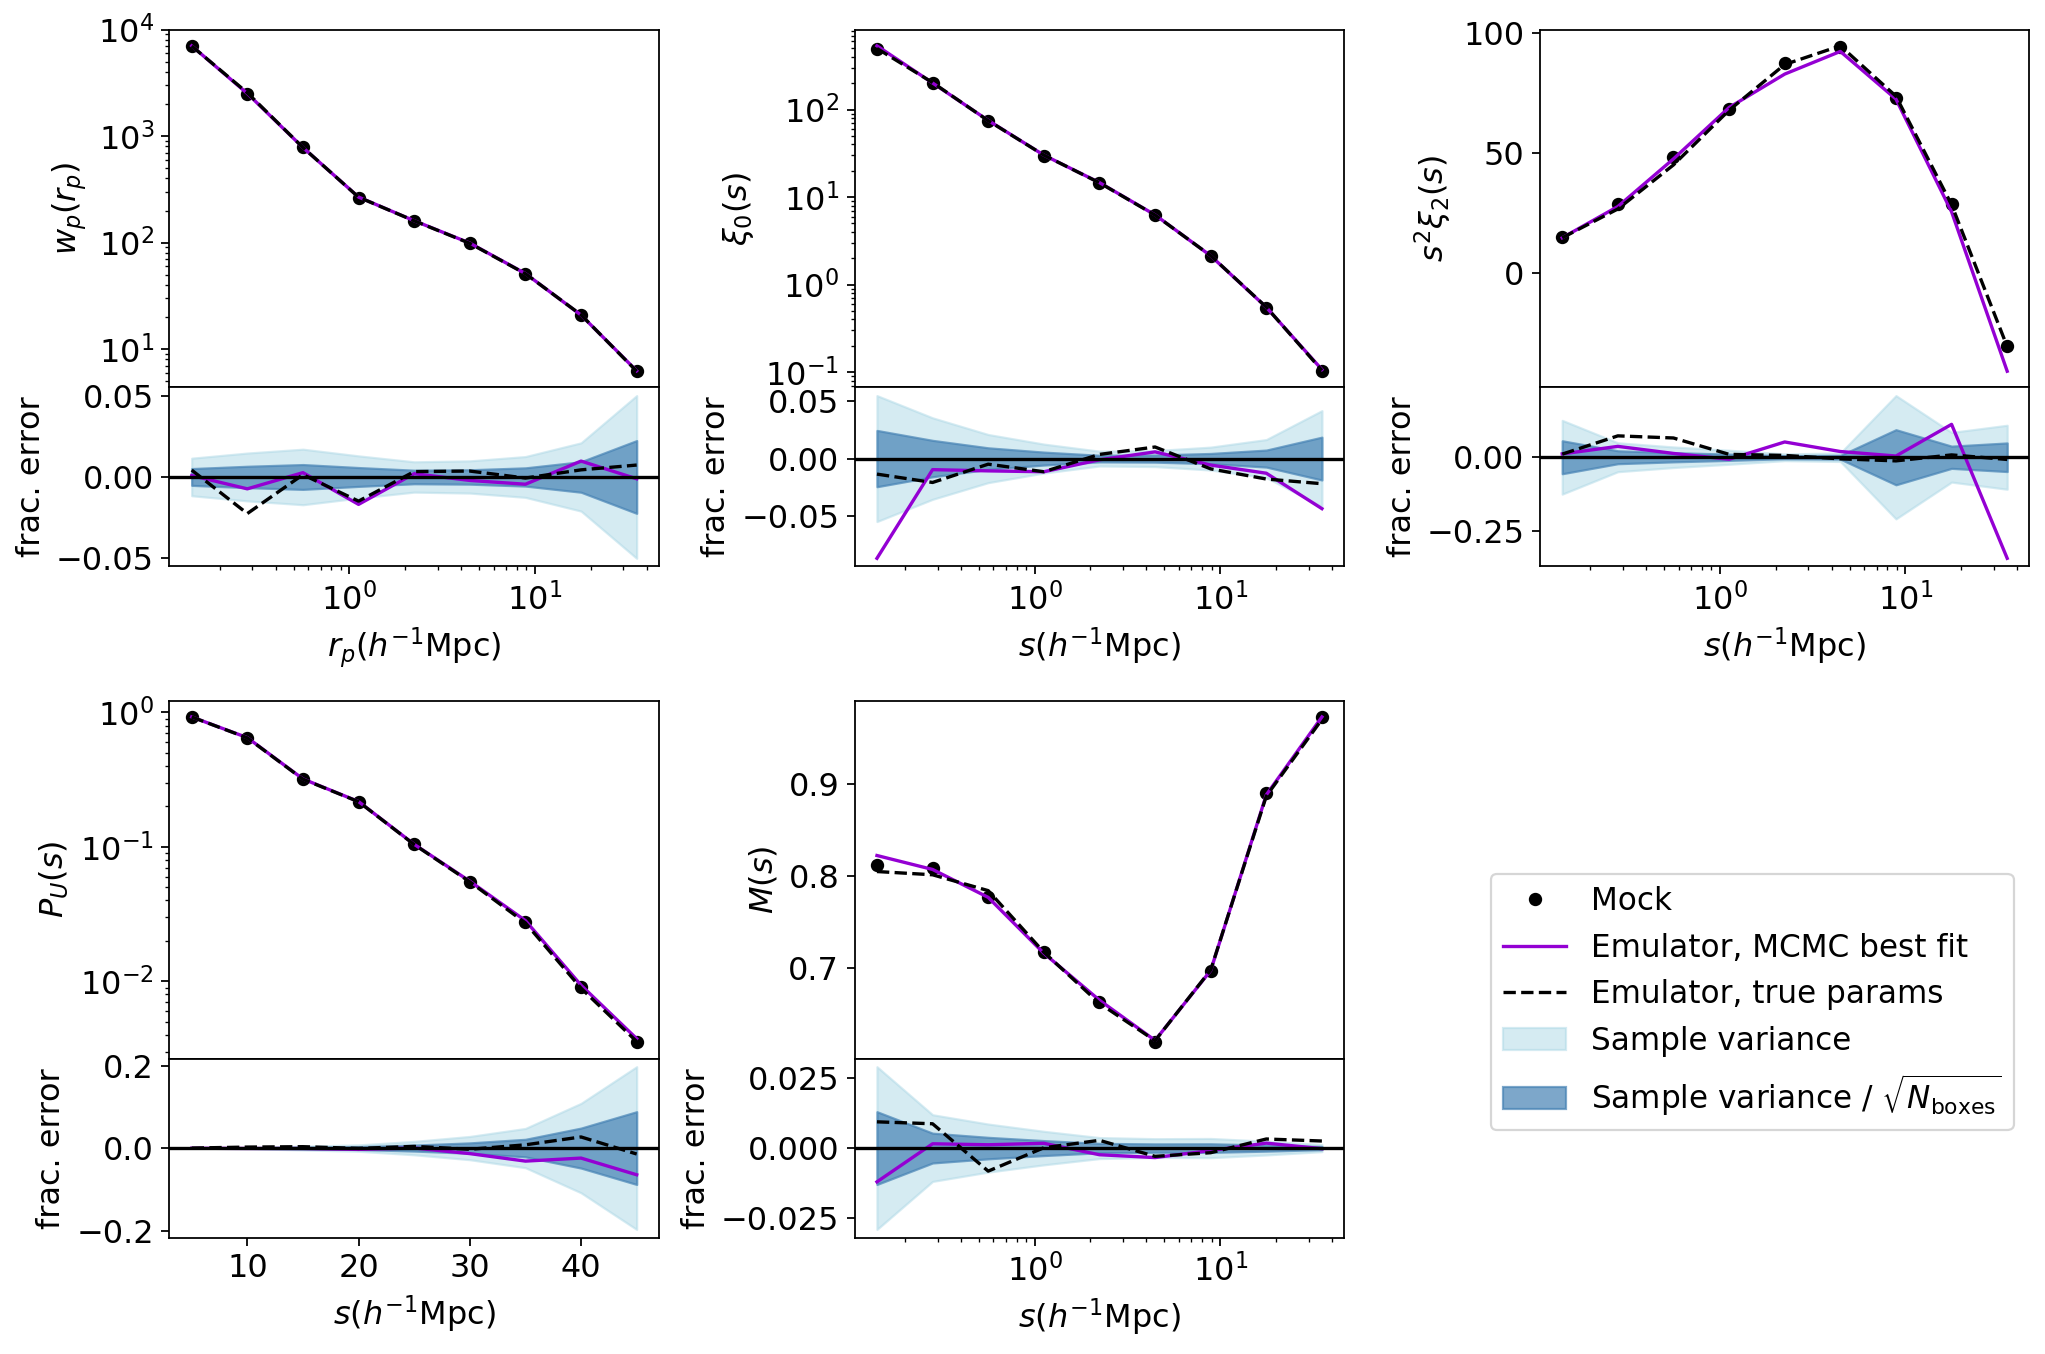

In [59]:
plot_best_fit_figure(statistics)

## Effect of covariance matrix

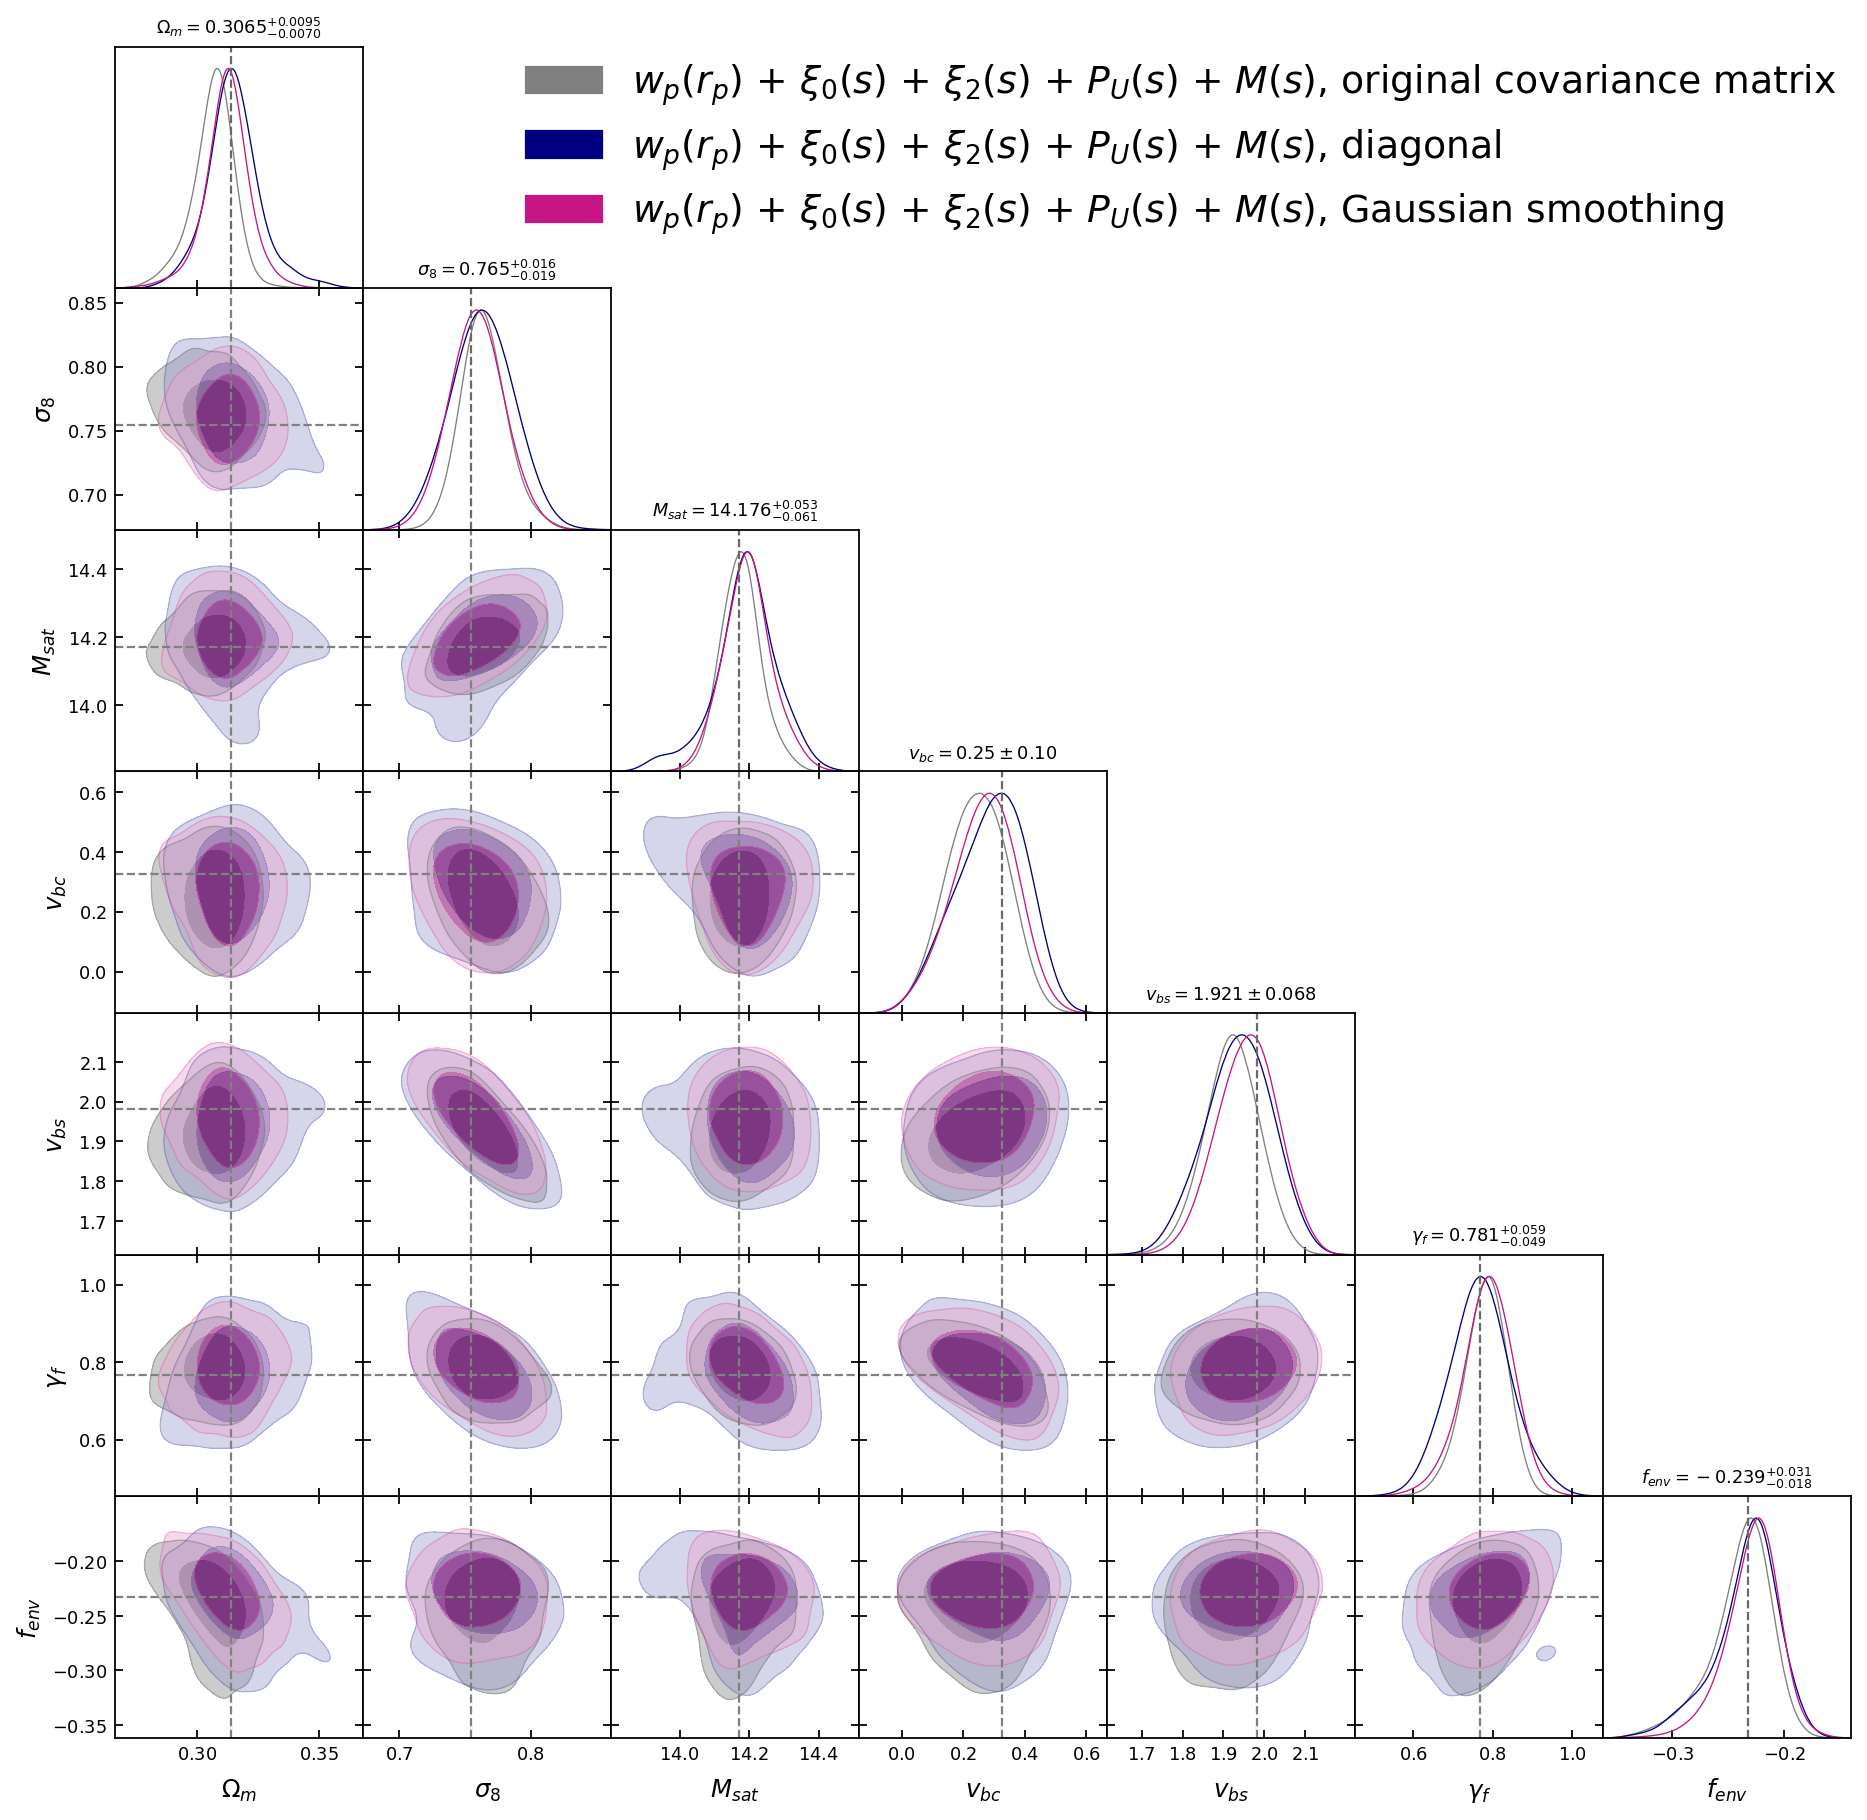

In [60]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c1h12_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c1h12_all_covdiag',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
legend_labels = [
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', original covariance matrix',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', diagonal',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', Gaussian smoothing',

                ]
colors = [
          'grey',
          'navy',
          'mediumvioletred',
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=key_param_names)

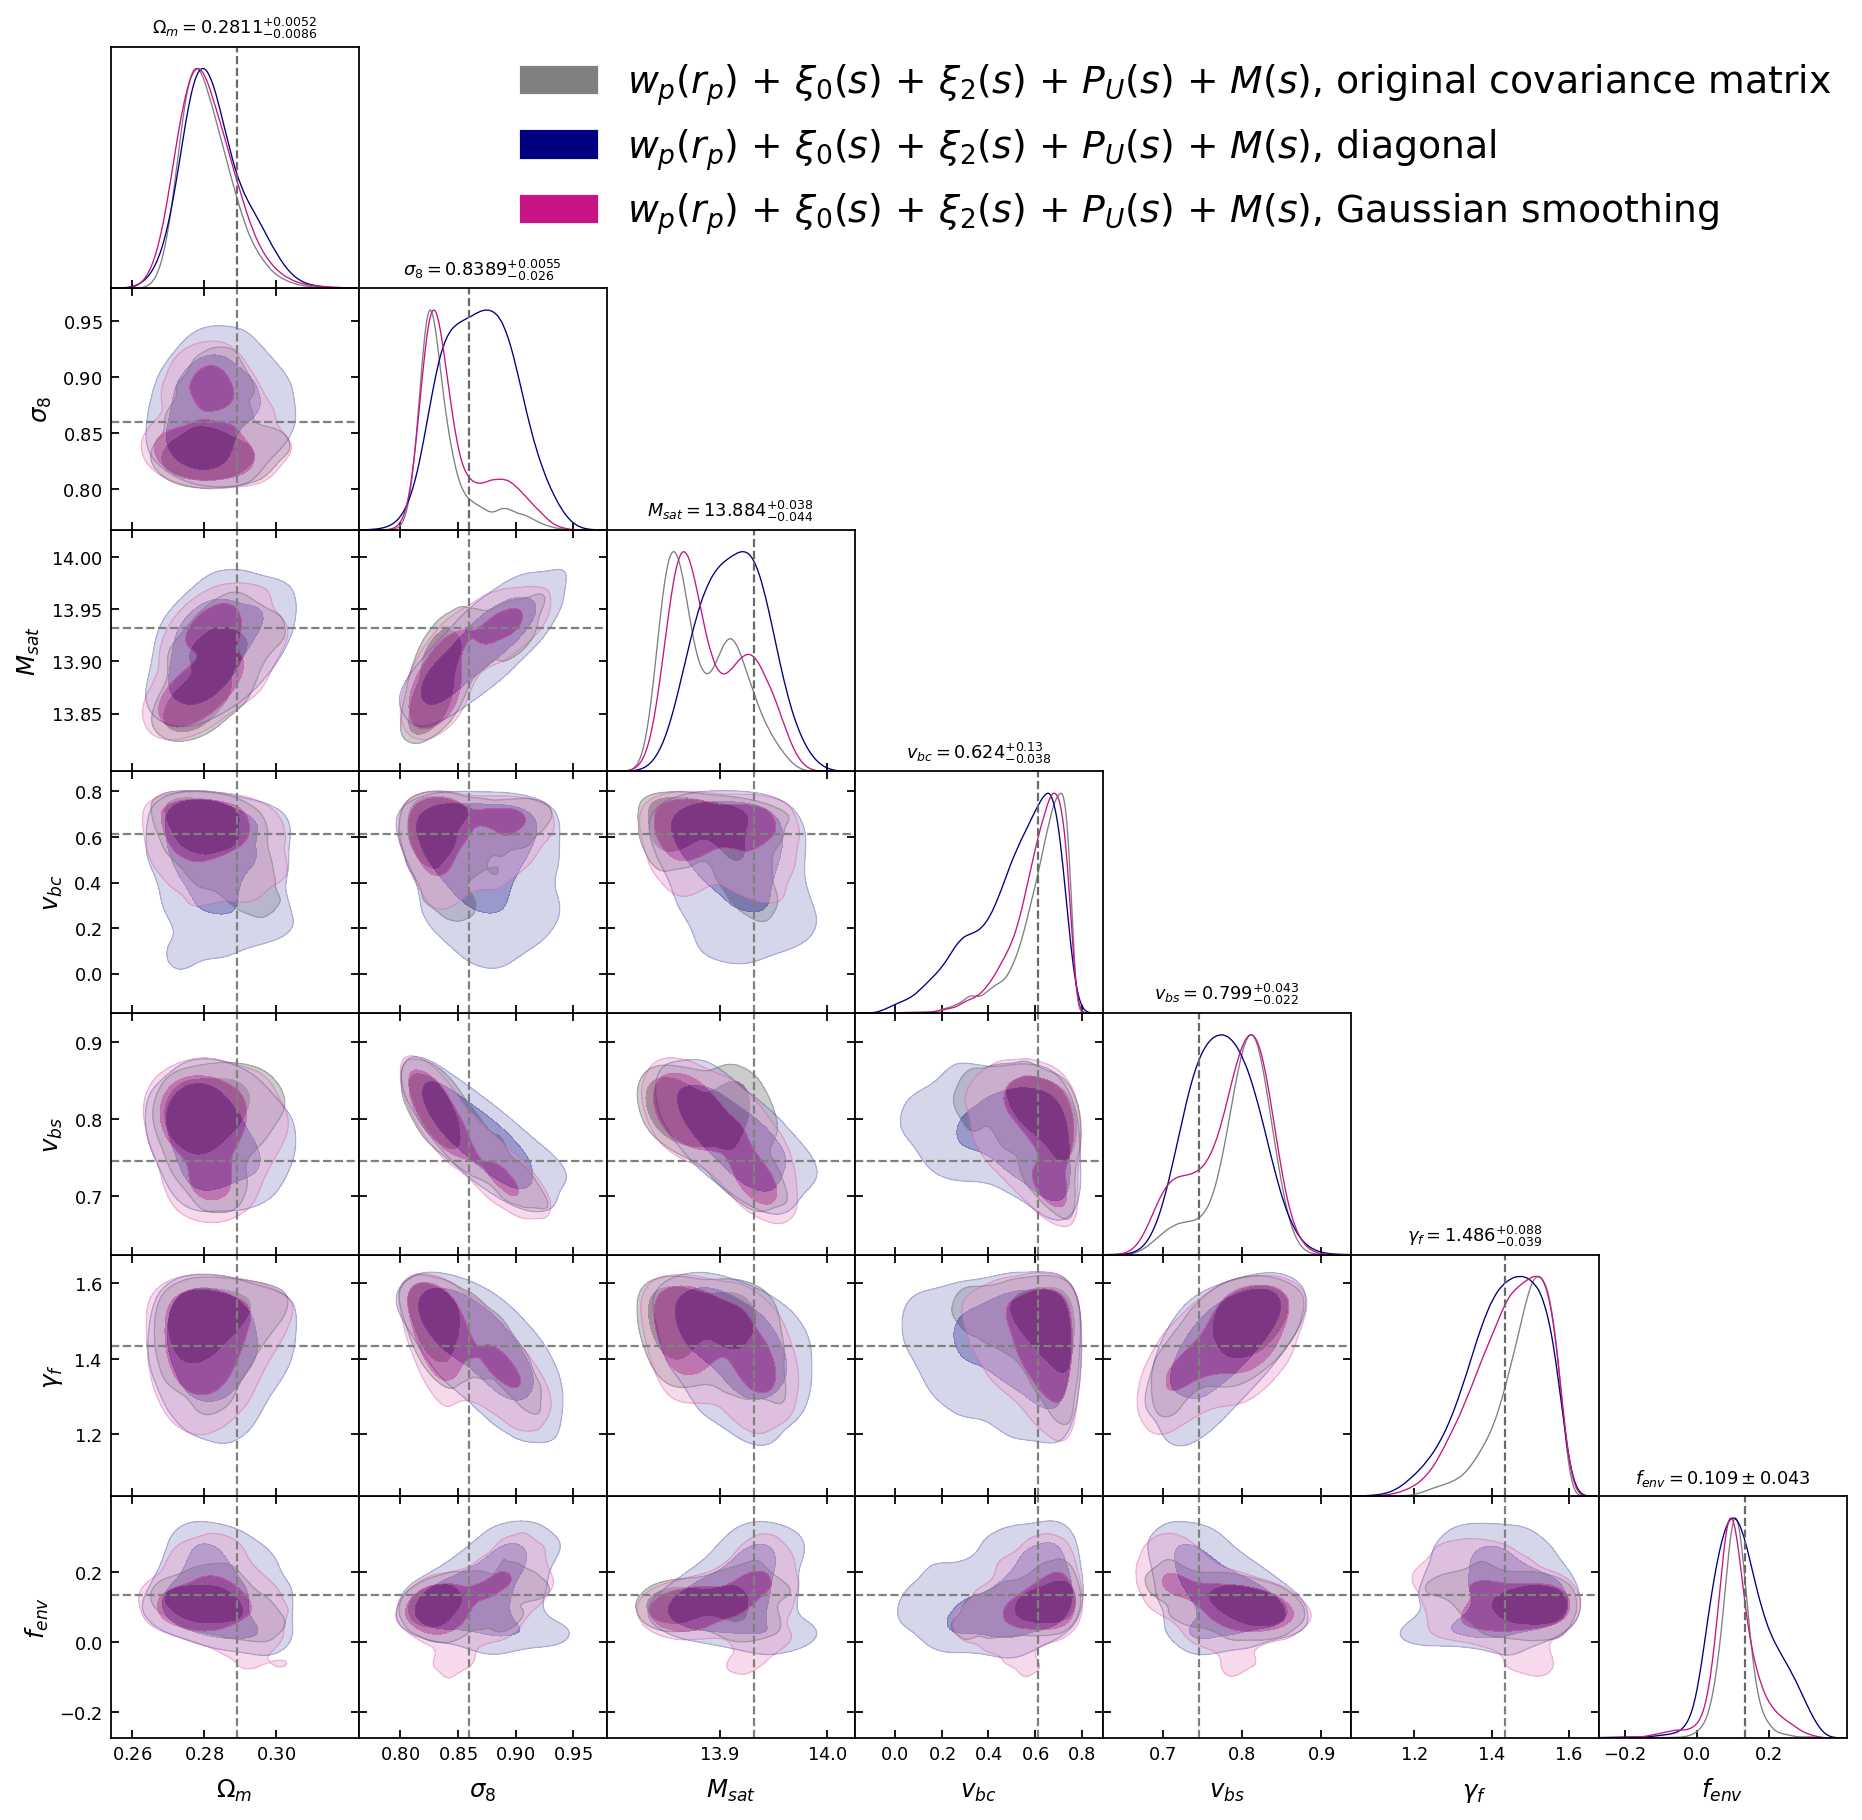

In [61]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c3h32_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c3h32_all_covdiag',
             'wp_xi_xi2_upf_mcf_c3h32_all',
            ]
legend_labels = [
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', original covariance matrix',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', diagonal',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', Gaussian smoothing',

                ]
colors = [
          'grey',
          'navy',
          'mediumvioletred',
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=key_param_names)

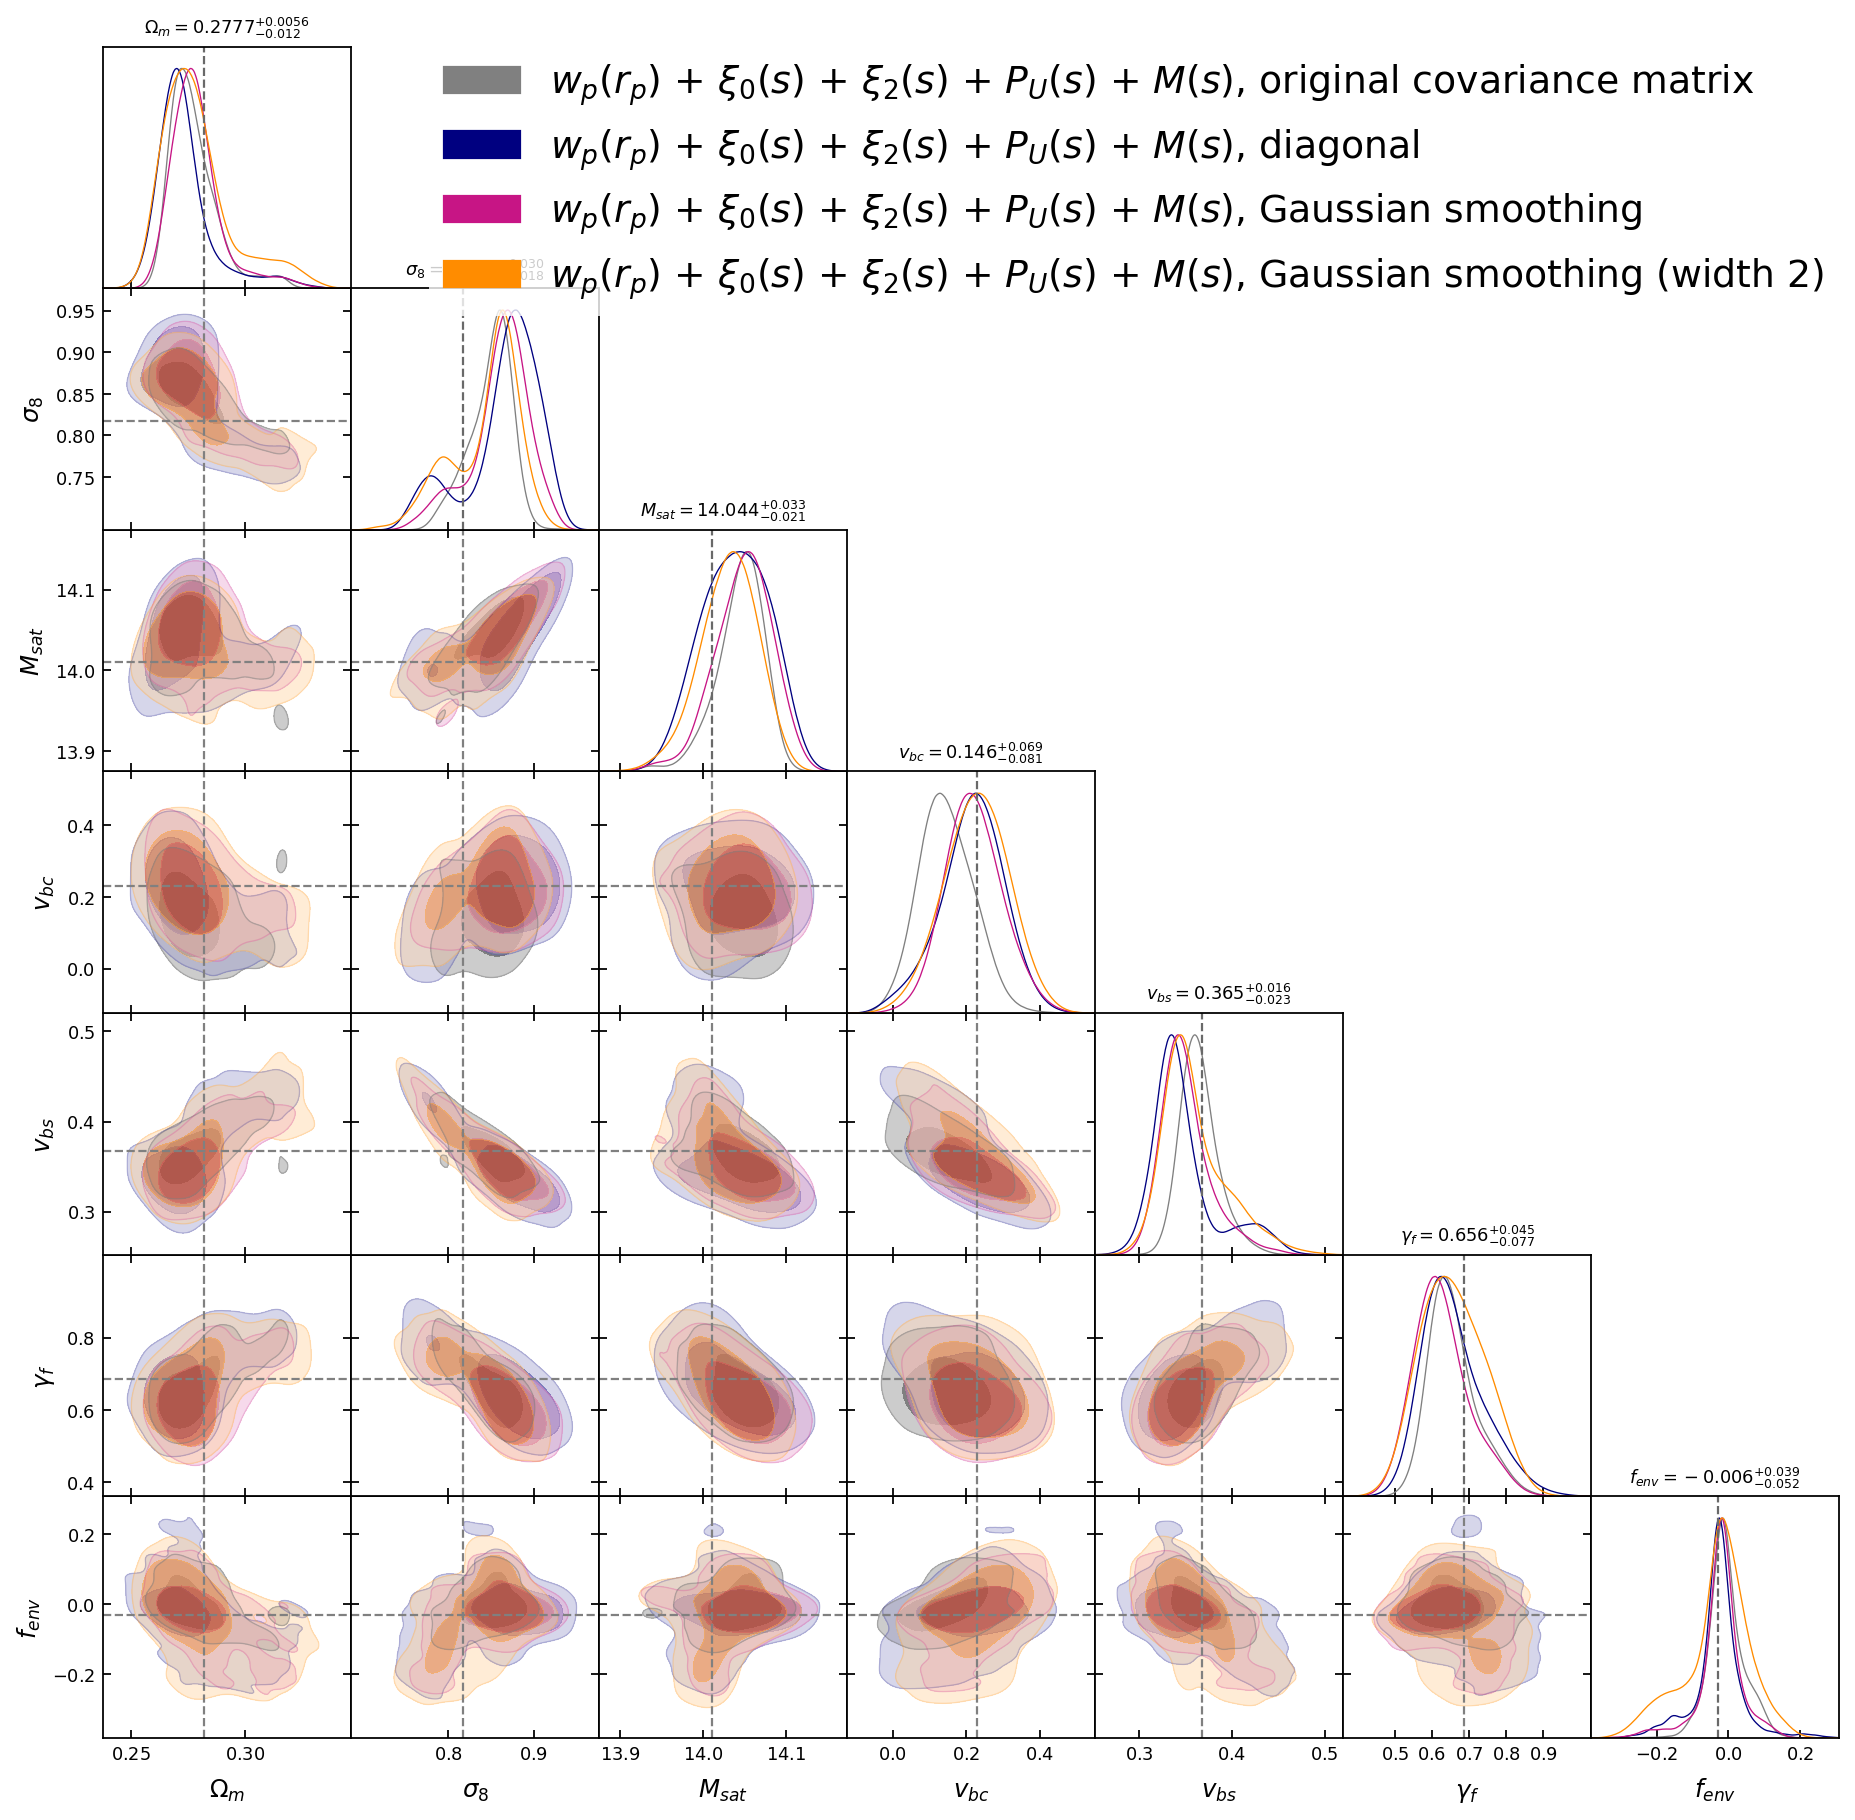

In [63]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c5h52_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c5h52_all_covdiag',
             'wp_xi_xi2_upf_mcf_c5h52_all',
             'wp_xi_xi2_upf_mcf_c5h52_all_covsmoothgauss2',
            ]
legend_labels = [
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', original covariance matrix',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', diagonal',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', Gaussian smoothing',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + ', Gaussian smoothing (width 2)',

                ]
colors = [
          'grey',
          'navy',
          'mediumvioletred',
          'darkorange'
         ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors, legend_loc='upper right',
                          params_toplot=key_param_names)

## Covariance/Correlation matrices

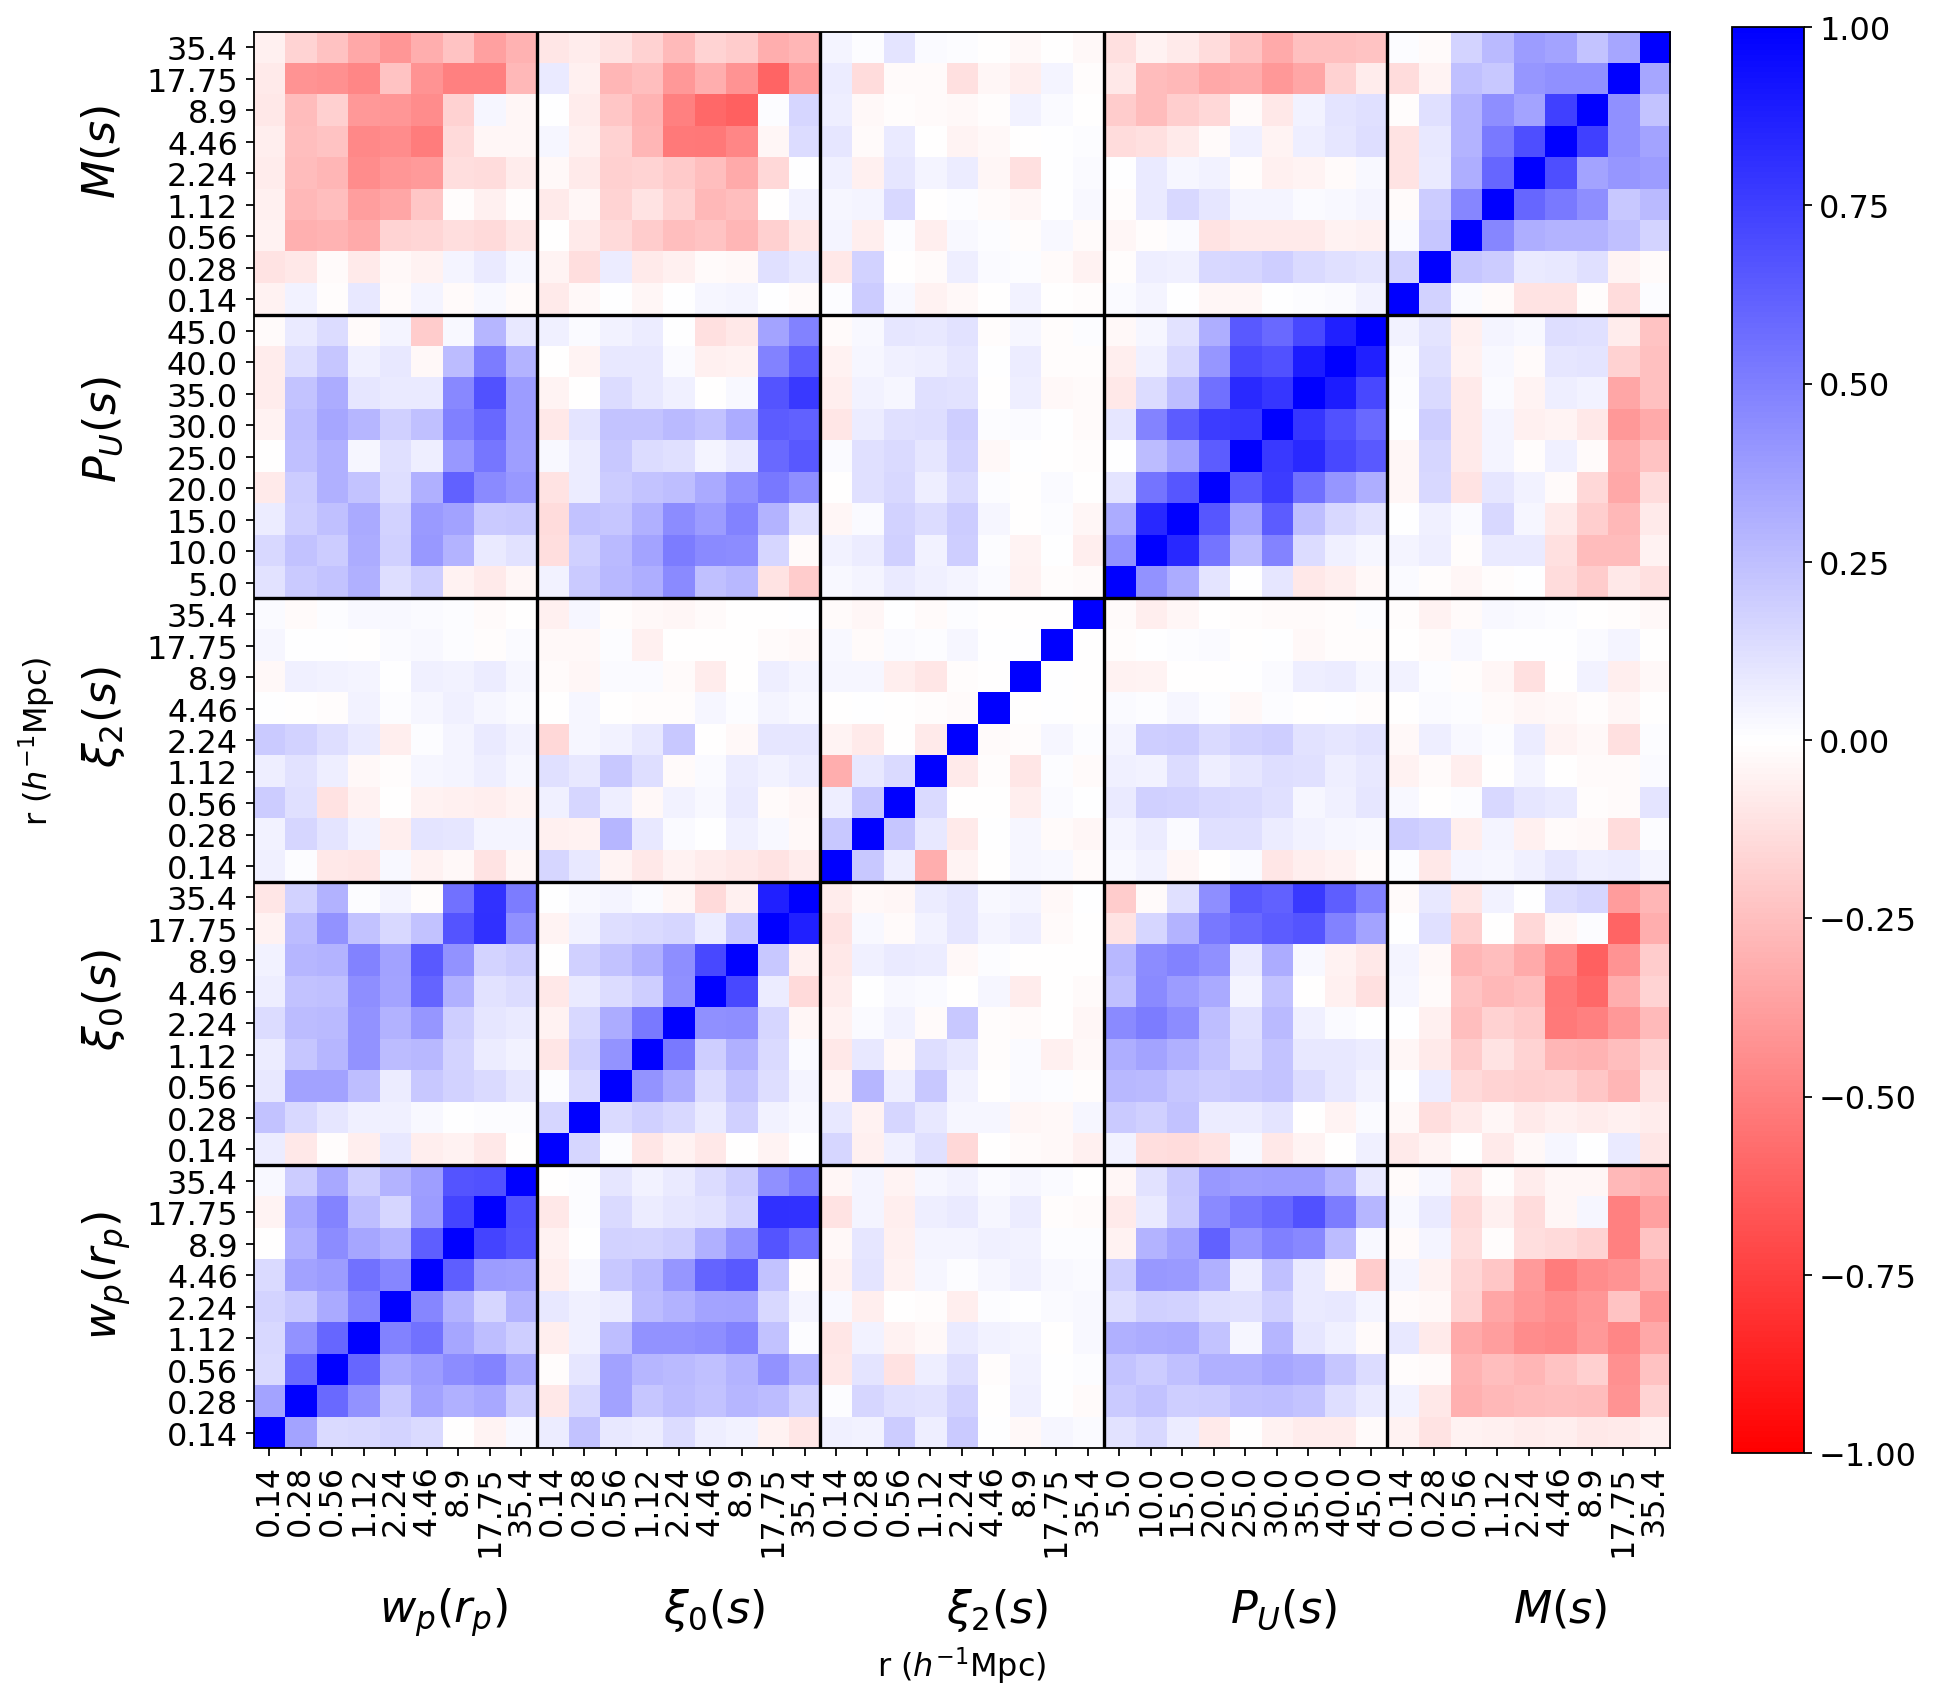

In [64]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']

cov_tag = 'emuperf'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)

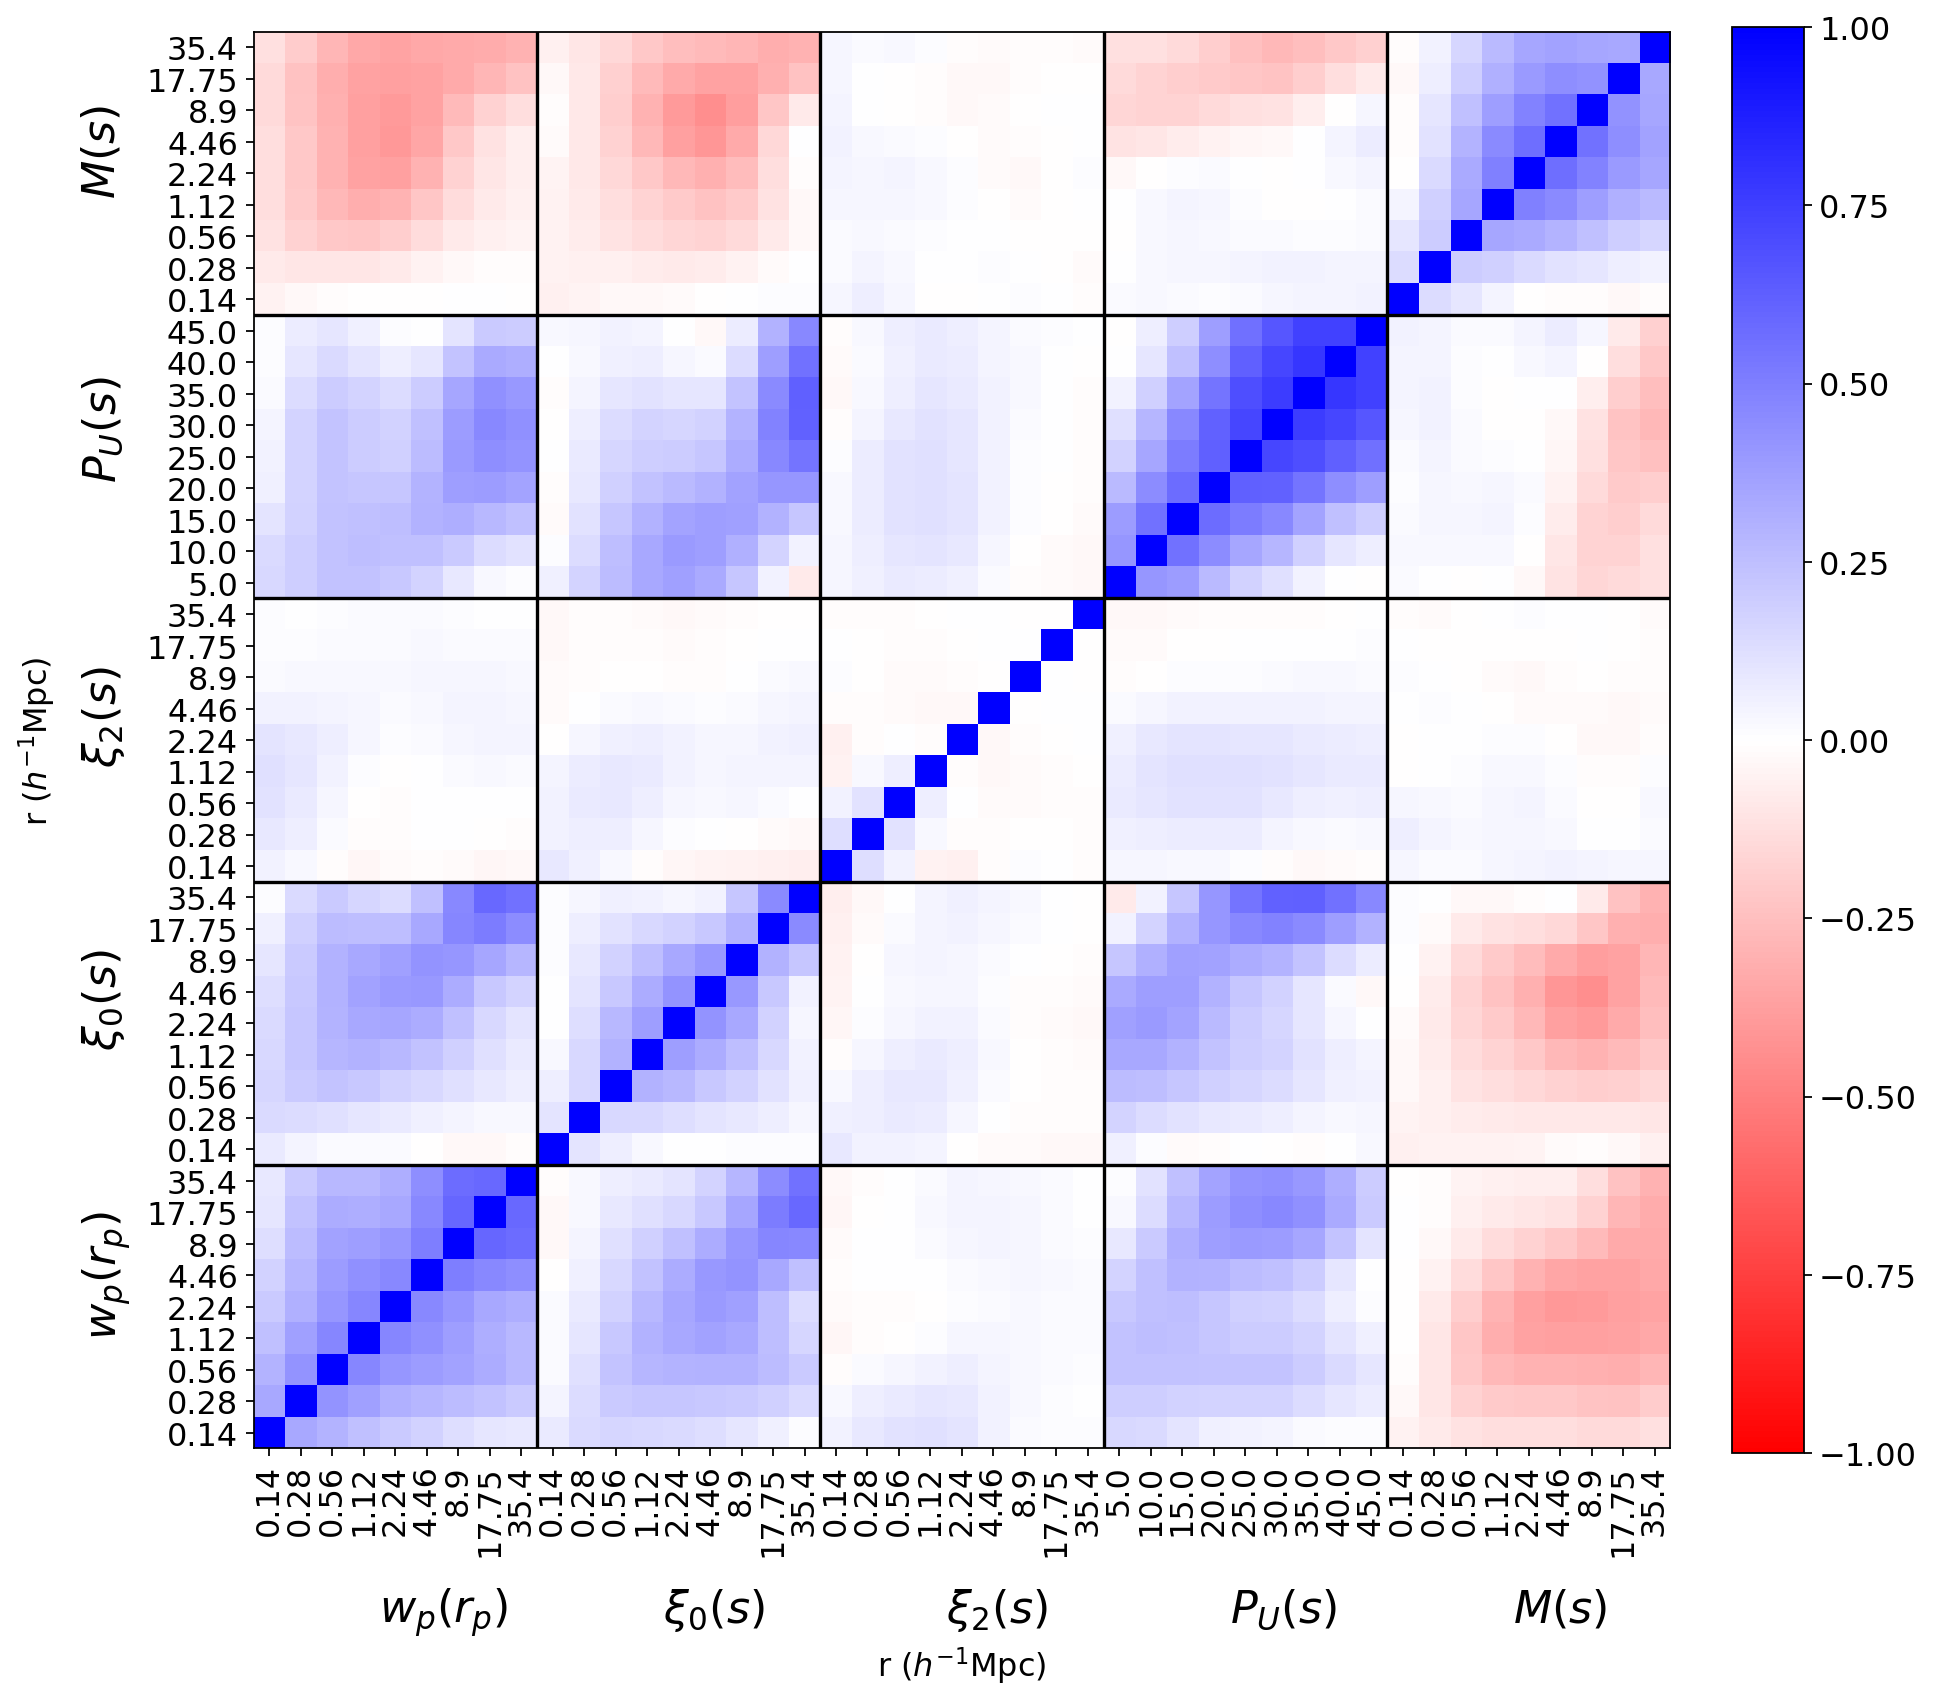

In [65]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']

cov_tag = 'smoothgauss_emuperf'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)

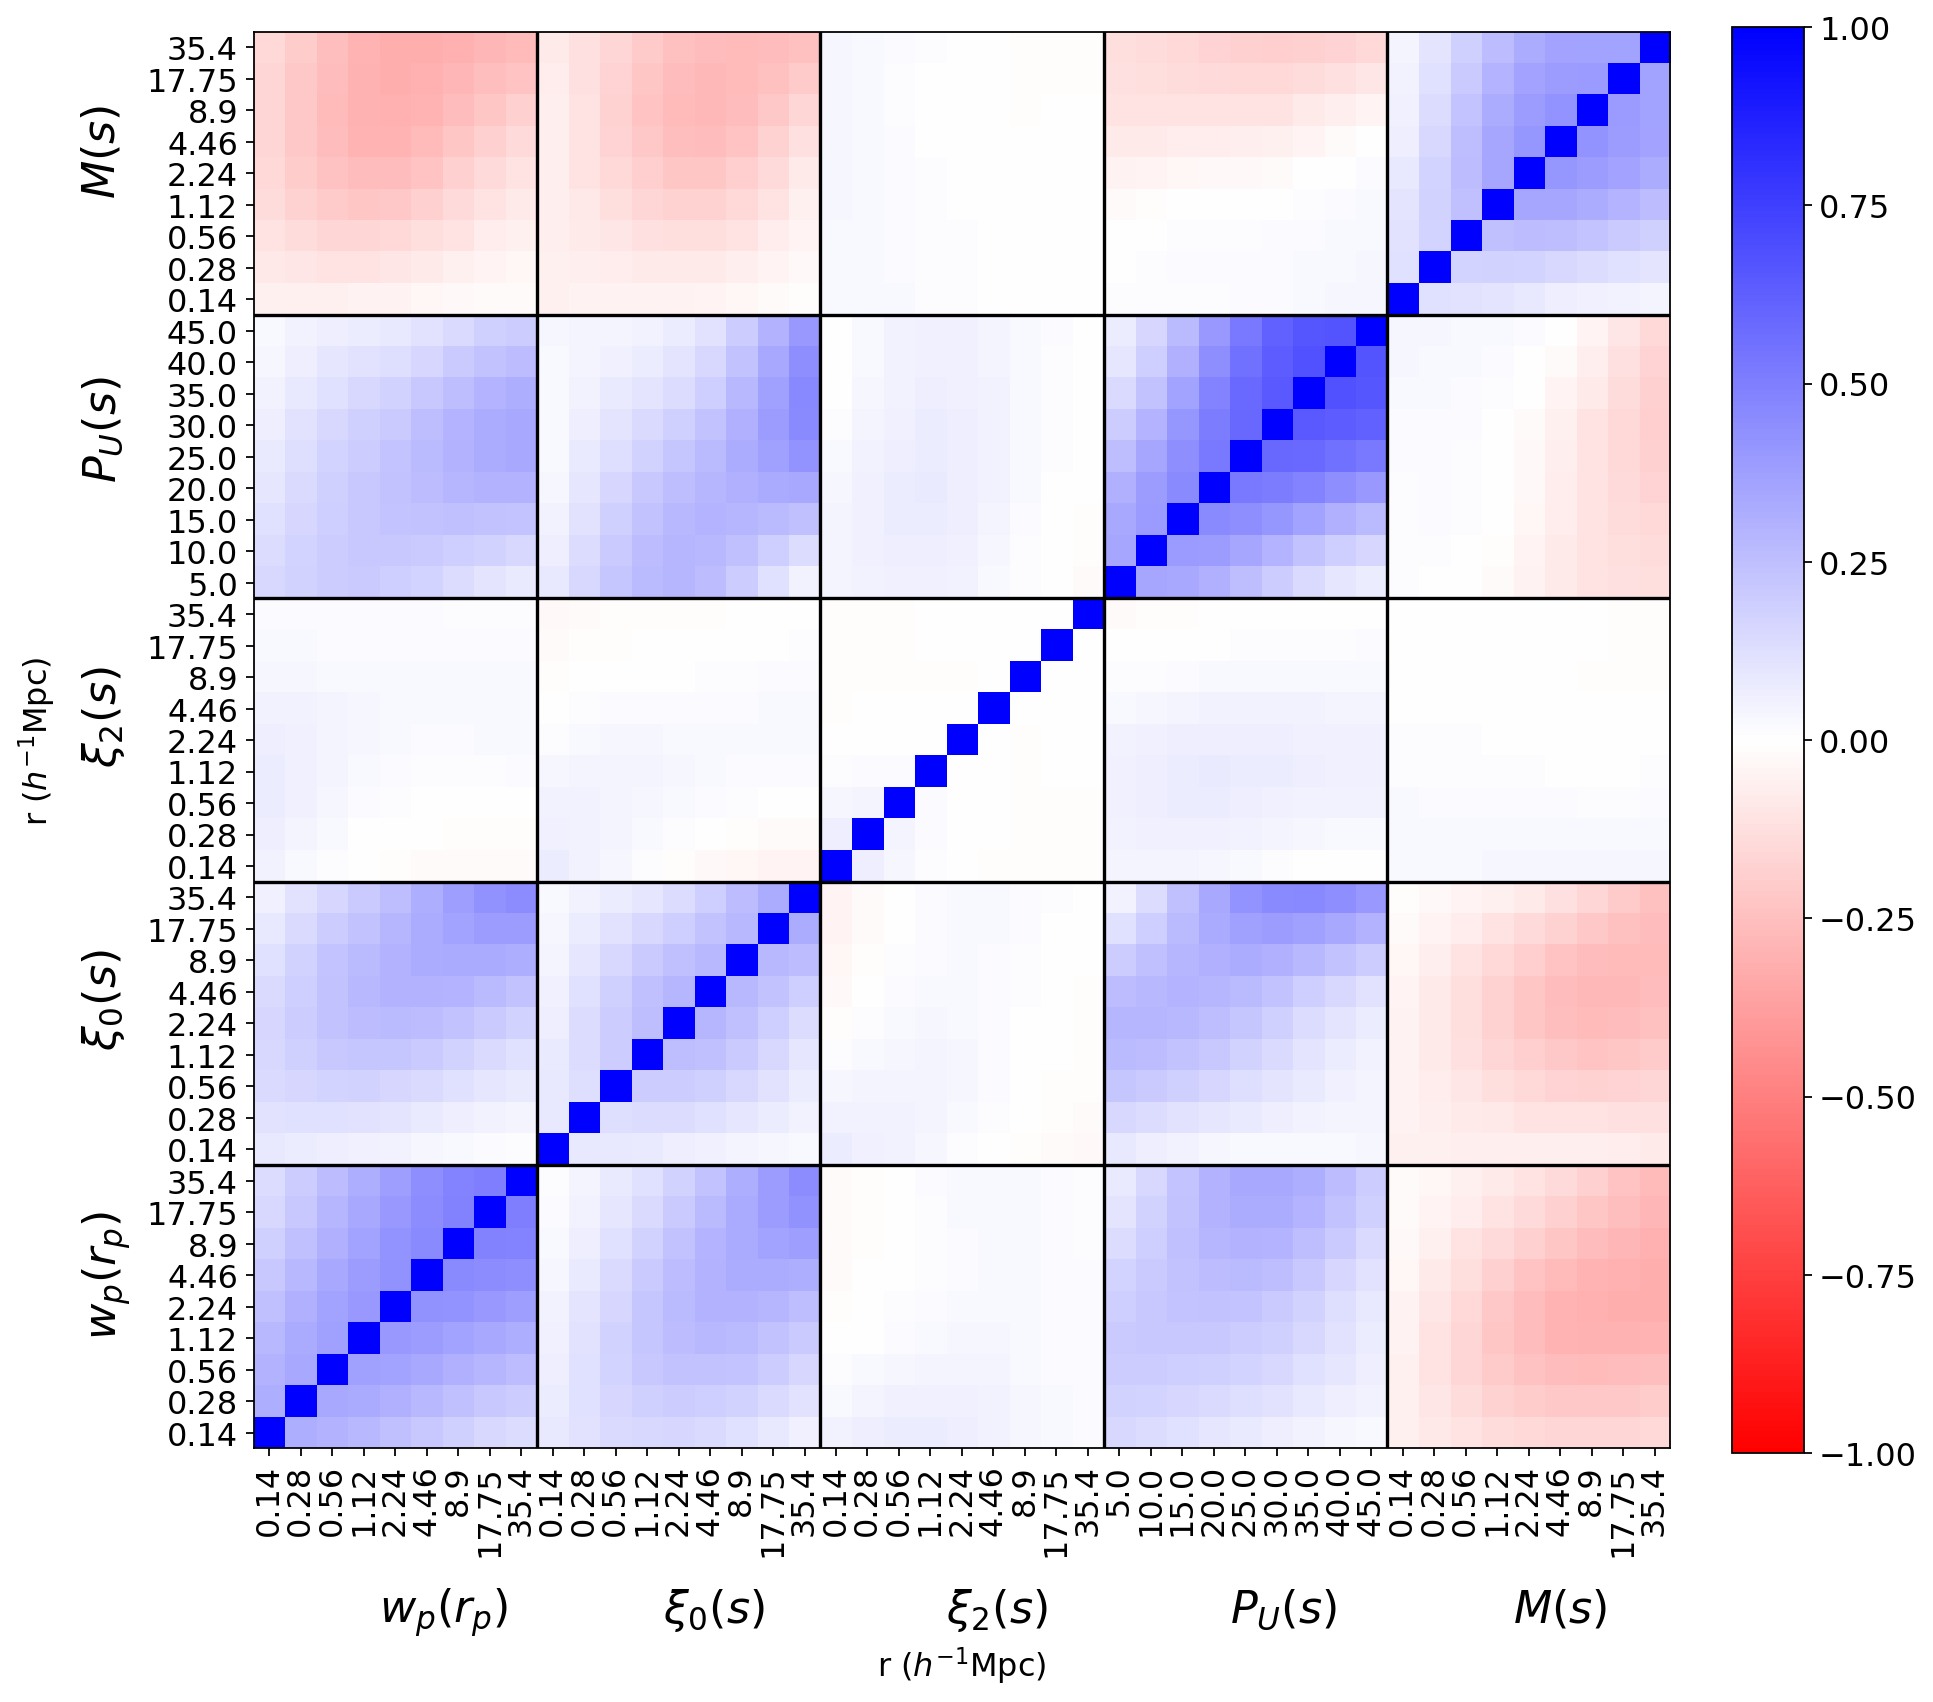

In [66]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']

cov_tag = 'smoothgauss2_emuperf'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)

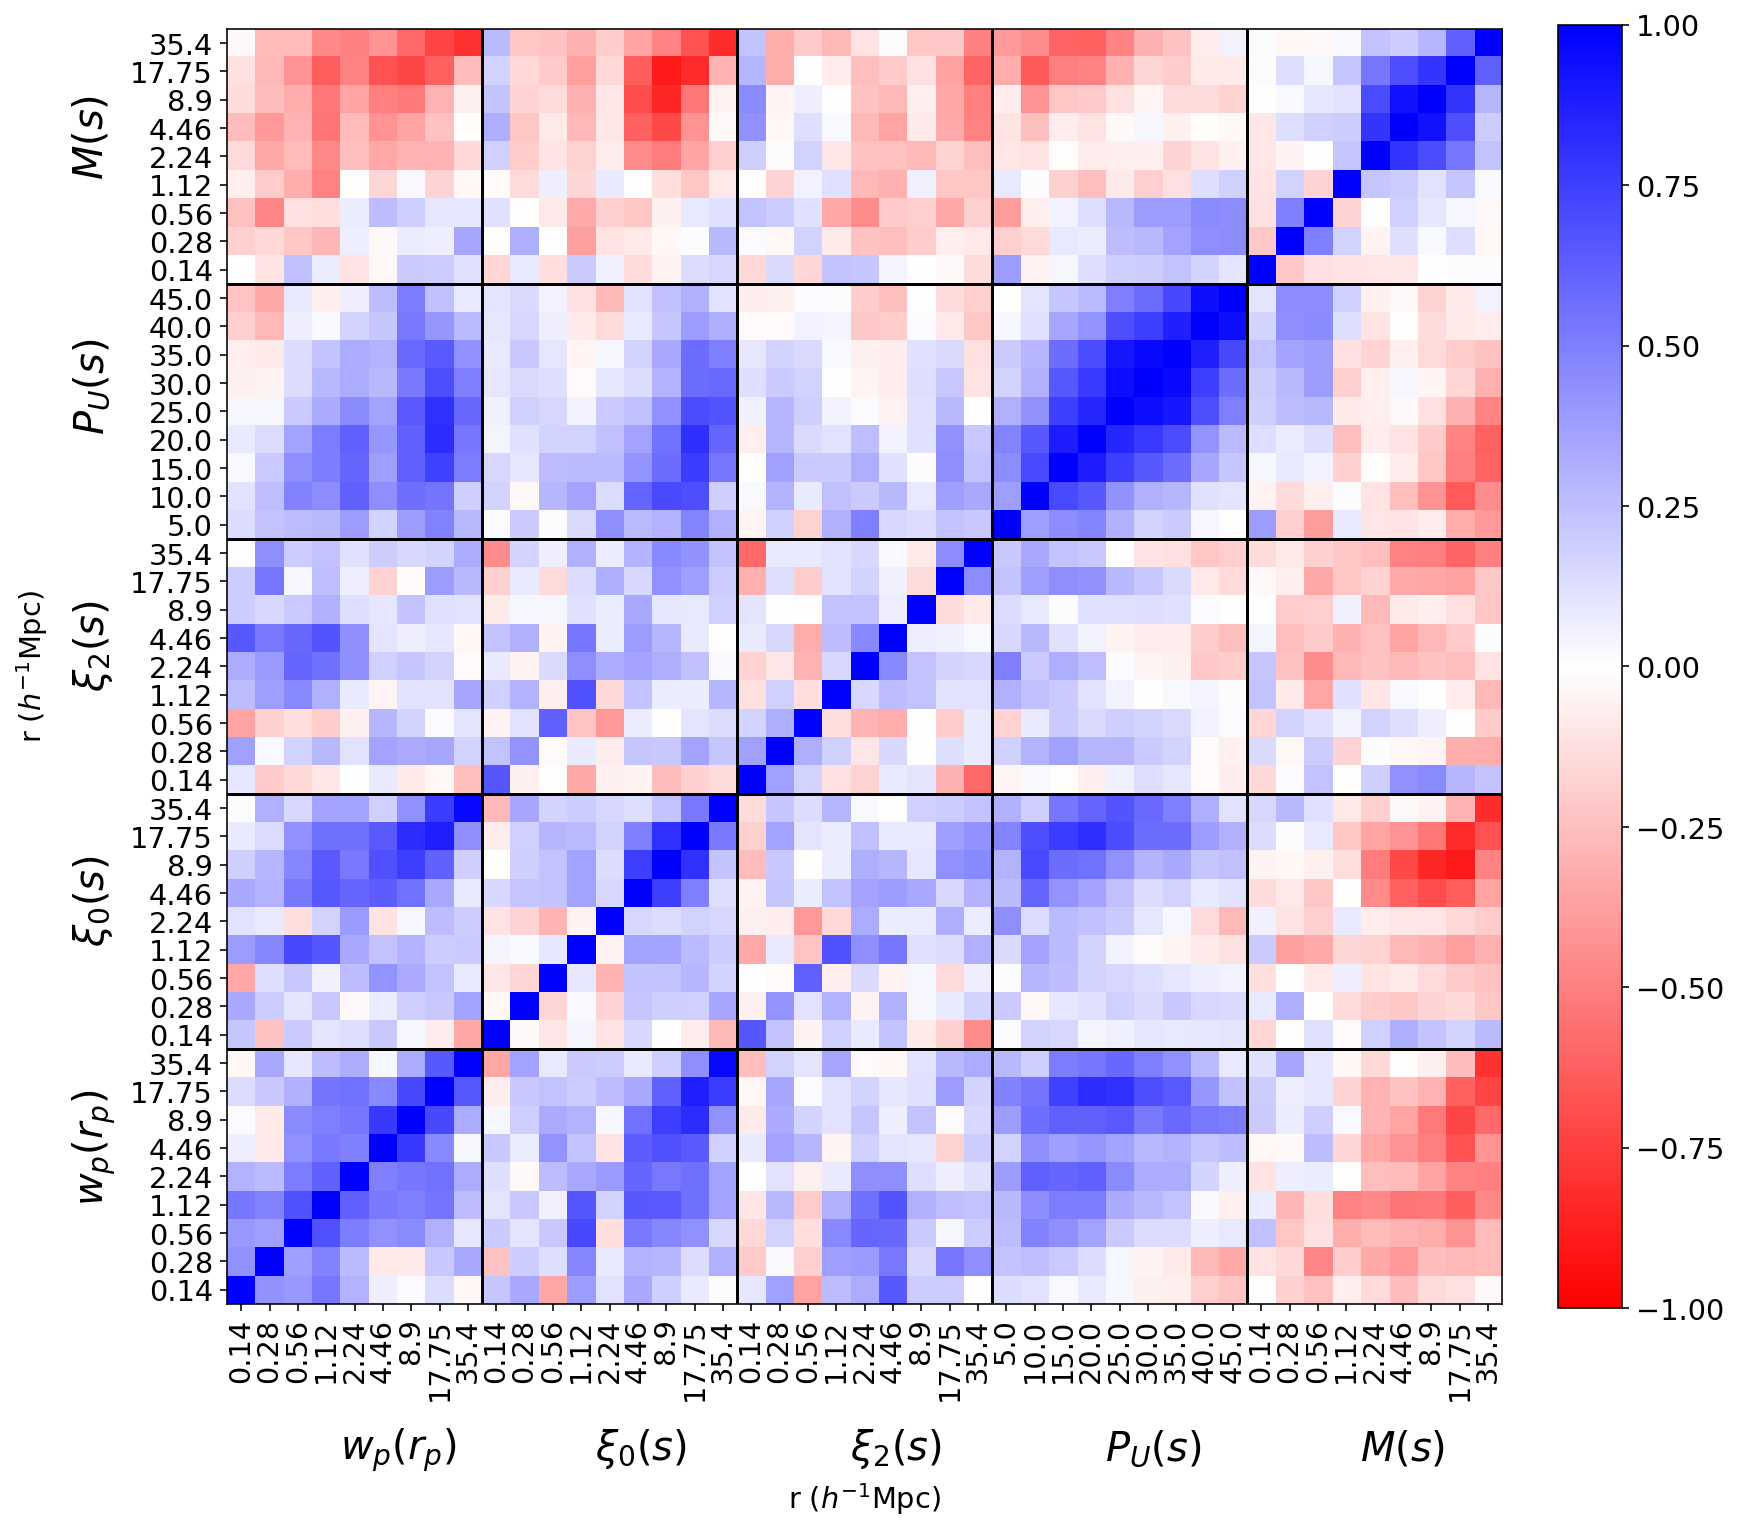

In [2]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']

cov_tag = 'aemulus'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)